The code is an implementation of a deep Q-learning algorithm to train an agent to solve the CartPole-v1 environment from the OpenAI Gym using PyTorch. 

The first part of the code defines the hyperparameters, including the learning rate, the number of episodes, and the discount factor. The size of the hidden layer, the size of the experience replay memory, the batch size, and the epsilon-greedy exploration parameters are also defined. 

The second part of the code defines a neural network class (NeuralNetwork) to serve as the function approximator for the Q-value function. The neural network consists of two linear layers followed by the tanh activation function. The QNet_Agent class serves as an agent that uses the neural network to select actions and optimize the Q-value function. 

The third part of the code defines an ExperienceReplay class that serves as a buffer to store the agent's experiences. The push method is used to add a new experience to the buffer, and the sample method is used to randomly sample a batch of experiences from the buffer. 

The code then initializes the experience replay memory, the QNet_Agent, and the environment. It then enters a loop to run the training process for a specified number of episodes. 

For each episode, the agent selects an action based on the current state of the environment and the current epsilon value (for epsilon-greedy exploration). The agent then takes a step in the environment, adds the experience to the replay memory, and optimizes the Q-value function using a batch of experiences randomly sampled from the replay memory. 

The code also tracks the total number of steps taken and the total number of frames rendered during the training process. The training process terminates if the agent successfully solves the environment (i.e., reaches an average reward of 195 over the last 100 episodes) or if the maximum number of episodes is reached. 

Finally, the code outputs the total time taken for the training process and a plot of the number of steps taken per episode. It also uses the QNet_Agent to play one episode in the environment to visualize the performance of the trained agent.

Finished after steps: 9

*** Episode 0 ***                       
Av.reward: [last 10]: 3.50, [last 100]: 0.35, [all]: 35.00                       
epsilon: 0.84, frames_total: 35
Elapsed time:  00:00:00

*** Episode 10 ***                       
Av.reward: [last 10]: 21.70, [last 100]: 2.52, [all]: 22.91                       
epsilon: 0.54, frames_total: 252
Elapsed time:  00:00:00

*** Episode 20 ***                       
Av.reward: [last 10]: 170.10, [last 100]: 19.53, [all]: 93.00                       
epsilon: 0.02, frames_total: 1953
Elapsed time:  00:00:02

*** Episode 30 ***                       
Av.reward: [last 10]: 238.70, [last 100]: 43.40, [all]: 140.00                       
epsilon: 0.00, frames_total: 4340
Elapsed time:  00:00:04

*** Episode 40 ***                       
Av.reward: [last 10]: 226.90, [last 100]: 66.09, [all]: 161.20                       
epsilon: 0.00, frames_total: 6609
Elapsed time:  00:00:07

*** Episode 50 ***                       
Av.reward:

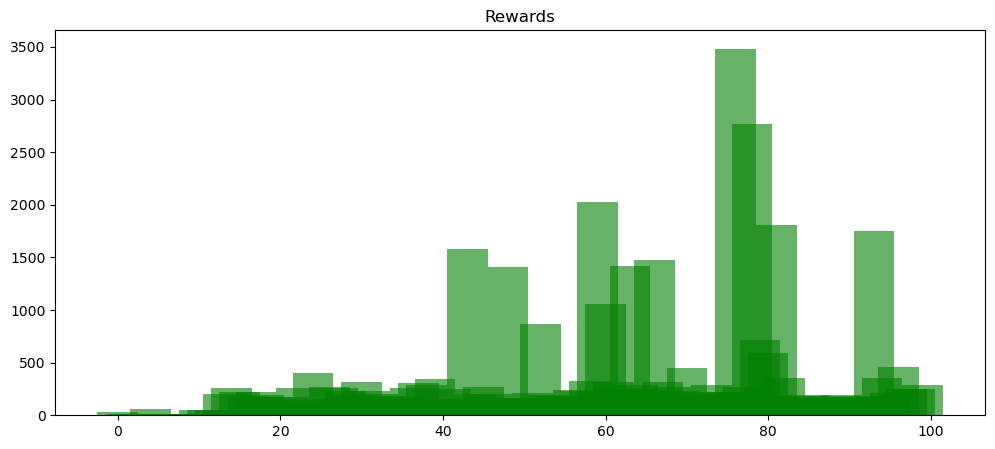

Finished after steps: 261
Finished after steps: 268
Finished after steps: 268
Finished after steps: 259
Finished after steps: 251
Finished after steps: 263
Finished after steps: 262
Finished after steps: 272
Finished after steps: 252
Finished after steps: 263


In [1]:

import torch                          # Importing the PyTorch library
import torch.nn as nn                 # Importing the neural network module of PyTorch
import torch.optim as optim           # Importing the optimization module of PyTorch
import gym                            # Importing the OpenAI gym library
import random                         # Importing the random module
import math                           # Importing the math module
import time                           # Importing the time module

import matplotlib.pyplot as plt       # Importing the pyplot module from the matplotlib library

use_cuda = torch.cuda.is_available()  # Checking if CUDA is available and setting a flag accordingly

device = torch.device("cuda:0" if use_cuda else "cpu")  # Assigning the device to be used for computations based on the availability of CUDA

Tensor = torch.Tensor                # Creating a shortcut for the Tensor class of PyTorch
LongTensor = torch.LongTensor        # Creating a shortcut for the LongTensor class of PyTorch

env = gym.make('CartPole-v1')         # Creating an instance of the CartPole-v1 environment from OpenAI gym

seed_value = 23                       # Setting a seed value to reproduce the same random results
torch.manual_seed(seed_value)         # Setting the seed for the PyTorch library
random.seed(seed_value)               # Setting the seed for the random module


learning_rate = 0.02                  # Setting the learning rate for the optimizer
num_episodes = 100                    # Setting the number of episodes to run the agent for
gamma = 1                             # Setting the discount factor for the reward

hidden_layer = 64                     # Setting the size of the hidden layer of the neural network

replay_mem_size = 50000               # Setting the size of the replay memory
batch_size = 32                       # Setting the batch size for the optimizer

egreedy = 0.9                         # Setting the initial value of the epsilon-greedy parameter
egreedy_final = 0                     # Setting the final value of the epsilon-greedy parameter
egreedy_decay = 500                   # Setting the decay factor for the epsilon-greedy parameter

report_interval = 10                  # Setting the number of episodes after which to report the score
score_to_solve = 195                  # Setting the minimum score required to solve the environment

# Get the number of inputs and outputs for the environment
number_of_inputs = env.observation_space.shape[0]
number_of_outputs = env.action_space.n 

# Define a function to calculate the epsilon value for the e-greedy policy
def calculate_epsilon(steps_done):
    # Calculate epsilon value based on the current number of steps taken
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

# Define a neural network class that extends the PyTorch nn.Module class
class NeuralNetwork(nn.Module): 
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Define the first linear layer with the specified number of inputs and hidden layer size
        self.linear1 = nn.Linear(number_of_inputs, hidden_layer) 
        # Define the second linear layer with the hidden layer size and the number of outputs
        self.linear2 = nn.Linear(hidden_layer, number_of_outputs) 
        # Define the activation function to use
        self.activation = nn.Tanh()
             
    def forward(self, x):
        # Pass the input through the first linear layer and the activation function
        output1 = self.linear1(x) 
        output1 = self.activation(output1)
        # Pass the output of the first layer through the second linear layer to get the final output
        output2 = self.linear2(output1)
        return output2

class QNet_Agent(object):
    def __init__(self):
        # Instantiate the neural network and move it to the device (CPU or GPU)
        self.nn = NeuralNetwork().to(device)
        # Define the loss function to be mean squared error
        self.loss_func = nn.MSELoss()      
        # Define the optimizer to be Adam, using the learning rate defined earlier
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)

        
    def select_action(self,state,epsilon):
        # Generate a random number between 0 and 1 to decide whether to choose a random action (for exploration)
        random_for_egreedy = torch.rand(1)[0]
        
        if random_for_egreedy > epsilon: # Choose the best action predicted by the neural network
            
            with torch.no_grad(): # Turn off gradients since we are not training the network in this step
                
                state = Tensor(state).to(device) # Convert the state to a tensor and move it to the device
                action_from_nn = self.nn(state) # Pass the state to the neural network to get the Q values for each action
                action = torch.max(action_from_nn,0)[1] # Choose the action with the highest Q value
                action = action.item() # Convert the action tensor to a scalar
        else: # Choose a random action
            action = env.action_space.sample()
        
        return action
    
    def optimize(self):
        # If there are not enough memories in the replay memory, skip this step
        if (len(memory) < batch_size):
            return
        
        # Sample a batch of memories from the replay memory
        state, action, new_state, reward, done = memory.sample(batch_size)
        
        # Convert the data to tensors and move them to the device
        state = Tensor(state).to(device) 
        new_state = Tensor(new_state).to(device)
        reward = Tensor(reward).to(device)
        action = LongTensor(action).to(device)
        done = Tensor(done).to(device)

        # Compute the Q values for the new states, but do not compute gradients for this step
        new_state_values = self.nn(new_state).detach()
        # Choose the maximum Q value for each new state
        max_new_state_values = torch.max(new_state_values, 1)[0]
        # Compute the target value for each state
        target_value = reward + ( 1 - done ) * gamma * max_new_state_values
  
        # Compute the Q value for each state-action pair
        predicted_value = self.nn(state).gather(1, action.unsqueeze(1)).squeeze(1)
        
        # Compute the loss between the predicted Q values and the target Q values
        loss = self.loss_func(predicted_value, target_value)
    
        # Zero out the gradients in the optimizer
        self.optimizer.zero_grad()
        # Backpropagate the loss to compute gradients
        loss.backward()
        # Update the weights of the neural network using the gradients
        self.optimizer.step()

class ExperienceReplay(object):
    def __init__(self, capacity):
        self.capacity = capacity  # capacity of the replay memory
        self.memory = []          # initialize the replay memory
        self.position = 0         # starting position of the memory
 
    def push(self, state, action, new_state, reward, done):
        # Add a new transition to the replay memory
        
        transition = (state, action, new_state, reward, done)
        
        # If the replay memory is not full, append the new transition to the end
        if self.position >= len(self.memory): 
            self.memory.append(transition)
        # If the replay memory is full, overwrite the oldest transition with the new one
        else:
            self.memory[self.position] = transition
        self.position = ( self.position + 1 ) % self.capacity  # update the current position in the memory
        
    def sample(self, batch_size):
        # Sample a batch of transitions from the replay memory
        
        # Randomly select batch_size transitions from the replay memory
        samples = random.sample(self.memory, batch_size)
        
        # Transpose the batch of transitions so that the states, actions, etc. are grouped together
        # (i.e. separate lists for states, actions, etc.)
        return zip(*samples)
        
    def __len__(self):
        # Return the length of the replay memory
        
        return len(self.memory)

# Create a memory object with the specified replay memory size
memory = ExperienceReplay(replay_mem_size)

# Create a QNet_Agent object
qnet_agent = QNet_Agent()

# Put the neural network in evaluation mode, which disables certain operations such as dropout
qnet_agent.nn.eval()

# Create an environment object with the 'CartPole-v1' environment and enable rendering
env = gym.make('CartPole-v1', render_mode='human')

# Repeat the following for the specified number of episodes
for episode in range(10):

    # Reset the environment and get the initial state and associated variables
    state, _ = env.reset()

    # Pause for a moment to allow the user to view the initial state
    time.sleep(1.)

    # Repeat the following for a maximum of 10000 steps
    for step in range(10000):

        # Render the current state of the environment to the screen
        env.render()

        # Pause for a moment to allow the user to view the current state
        time.sleep(0.02)

        # Choose an action based on the current state using the QNet_Agent object with epsilon set to 0, meaning no exploration
        action = qnet_agent.select_action(state, 0)

        # Take the chosen action and get the resulting state, reward, and whether the episode is finished
        new_state, reward, done, _, _ = env.step(action)

        # Update the current state to the new state
        state = new_state

        # If the episode is finished, print the number of steps taken and break out of the loop
        if done:
            print('Finished after steps:', step)
            break

    # Break out of the loop after the first episode
    break

# Close the environment and the underlying OpenGL context
env.close()
env.env.close()

#Create a gym environment for CartPole-v1 game
env = gym.make('CartPole-v1')

#Set the neural network to training mode
qnet_agent.nn.train()

#Create empty list to store the total number of steps for each episode
steps_total = []

#Initialize the total number of frames seen to 0
frames_total = 0

#Set a variable to track how many episodes were completed before the game is solved
solved_after = 0

#Set a boolean variable to track if the game is solved
solved = False

#Record the starting time of the game
start_time = time.time()

# loop through the specified number of episodes
for i_episode in range(num_episodes):

    # reset the environment and get the initial state
    state, _ = env.reset()
    
    # set the initial step count to 0
    step = 0 

    # loop until the episode is done
    while True: 
        
        # increment the step count and total frame count
        step += 1 
        frames_total += 1 
        
        # calculate the current value of epsilon for the exploration-exploitation tradeoff
        epsilon = calculate_epsilon(frames_total) 
        
        # select an action using the Q-network agent's select_action() method, passing in the current state and epsilon value
        action = qnet_agent.select_action(state, epsilon) 
        
        # take a step in the environment with the selected action and get the resulting new state, reward, and done flag
        new_state, reward, done, _, _ = env.step(action) 

        # add the current state, action, new state, reward, and done flag to the experience replay memory
        memory.push(state, action, new_state, reward, done) 
        
        # optimize the Q-network agent's network weights using the experience replay memory and backpropagation
        qnet_agent.optimize() 
        
        # set the current state to the new state for the next iteration of the loop
        state = new_state 
         
        # if the episode is done
        if done: 
            # append the final step count to the list of step counts for this run
            steps_total.append(step) 
            
            # calculate the mean reward over the last 100 steps
            mean_reward_100 = sum(steps_total[-100:])/100
            
            # if the mean reward over the last 100 steps is greater than the threshold for solving the environment and the environment has not yet been solved
            if (mean_reward_100 > score_to_solve and solved == False):
                # print a message indicating that the environment has been solved and at what episode
                print("SOLVED! After %i episodes " % i_episode)
                solved_after = i_episode
                solved = True
            
            # if the current episode number is a multiple of the report interval
            if (i_episode % report_interval == 0):
                
                # print a message indicating the current episode number, the average reward over the last n steps, 
                #the mean reward over the last 100 steps, the overall mean reward, epsilon, and total frame count
                print("\n*** Episode %i *** \
                      \nAv.reward: [last %i]: %.2f, [last 100]: %.2f, [all]: %.2f \
                      \nepsilon: %.2f, frames_total: %i" 
                  % 
                  ( i_episode,
                    report_interval,
                    sum(steps_total[-report_interval:])/report_interval,
                    mean_reward_100,
                    sum(steps_total)/len(steps_total),
                    epsilon,
                    frames_total
                          ) 
                  )
                  
                # calculate and print the elapsed time since the start of training
                elapsed_time = time.time() - start_time
                print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

            # break out of the while loop since the episode is finished
            break

state_dict = qnet_agent.nn.state_dict()  # Get the state dictionary of the neural network of the agent
torch.save(state_dict, 'dqn_er4.pth')  # Save the state dictionary to a file named 'dqn_er4.pth'

print("\n\n\n\nAverage reward: %.2f" % (sum(steps_total)/num_episodes))  # Print the average reward across all episodes
print("Average reward (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))  # Print the average reward across the last 100 episodes
if solved:
    print("Solved after %i episodes" % solved_after)  # If the problem is solved, print the episode number where it was solved
plt.figure(figsize=(12,5))  # Create a new plot with the given size
plt.title("Rewards")  # Set the title of the plot to "Rewards"
plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='green', width=5)  # Plot the rewards over time as a bar chart
plt.show()  # Show the plot

env.close()  # Close the OpenAI Gym environment
env.env.close()  # Close the underlying environment (not strictly necessary, but it's a good practice to avoid potential issues)

# Load the saved state dictionary of the trained neural network
state_dict = torch.load('dqn_er4.pth')
# Load the state dictionary into the QNet_Agent's neural network
qnet_agent.nn.load_state_dict(state_dict)
# Set the QNet_Agent's neural network to evaluation mode
qnet_agent.nn.eval()
# Create a gym environment for the CartPole problem with human rendering mode
env = gym.make('CartPole-v1', render_mode = 'human')

# Run 10 episodes
for episode in range(10):
    # Reset the environment to obtain initial state
    state, _ = env.reset()
    # Wait for 1 second before the episode begins
    time.sleep(1.) 
    # Run up to 10000 steps in the episode
    for step in range(10000):
        # Render the environment
        env.render() 
        # Wait for 0.02 seconds before taking an action
        time.sleep(0.02) 
        # Select an action using the QNet_Agent with epsilon = 0 (greedy policy)
        action = qnet_agent.select_action(state, 0)
        # Take the selected action and obtain the next state, reward, done flag, and information
        new_state, reward, done, _, _ = env.step(action)
        # Update the current state to the new state
        state = new_state
        # If the episode is done (pole has fallen or reached 200 steps), print the number of steps and break
        if done:
            print('Finished after steps:', step)
            break
# Close the environment and the environment's underlying core
env.close()
env.env.close()

# Explanation of Results

The results show that the agent was able to solve the environment after 66 episodes. 

The average reward increased significantly over the course of the training, from 35 in the first 10 episodes before settling around 383.64 after the 100th episode. This suggests that the agent gradually learned how to perform better in the environment, improving its performance over time.

The epsilon value, which controls the exploration vs. exploitation trade-off, decreases over time. In the first episode, the epsilon value is 0.84, indicating that the agent is exploring the environment more than exploiting its knowledge. However, by the 20th episode, the epsilon value has decreased to 0.02, indicating that the agent is exploiting its knowledge of the environment more than exploring. This is likely due to the fact that the agent is learning more about the environment and can make more informed decisions.

The frames_total value, which indicates the total number of frames the agent has processed, increases over time. This is expected since the agent is continuously interacting with the environment and learning from it.

Finally, there are some variations in the number of steps required to finish the training, as indicated by the "Finished after steps" messages at the end of the output. This is because the training process involves some randomness, and the exact number of steps required to solve the environment can vary between different runs.

# Hyperparameter Tuning

There are 9 hyperparameters that can be tuned for best results.

'learning_rate': Learning rate is a hyperparameter that controls how much the weights of the neural network are adjusted with each update. It is a crucial parameter in training a neural network, as a value that is too high can cause the weights to oscillate and diverge, while a value that is too low can lead to slow convergence. In this code, the learning rate is set to 0.02. To test for best results I will use 0.01 and 0.001.

'num_episodes': The number of episodes is the total number of times the agent plays the game. One episode consists of the agent starting at a random state and taking actions until it reaches a terminal state (i.e., the game is won or lost). The agent's performance is evaluated at the end of each episode, and the weights of the neural network are updated based on the experience gained during that episode. The num_episodes hyperparameter controls how many times the agent will play the game and, therefore, the number of times the weights of the neural network will be updated. In this code, the number of episodes is set to 100. To test for best results I will use 150 and 200.

'gamma': Gamma is a hyperparameter that controls the discount factor for future rewards in the reinforcement learning algorithm. It is a value between 0 and 1 and determines how much weight the agent places on future rewards. A value of 0 means that the agent only considers immediate rewards, while a value of 1 means that the agent considers all future rewards equally. In this code, gamma is set to 1. To test for best results I will use 0.99.

'hidden_layer': The hidden layer is a layer in the neural network that is not directly connected to the input or output layers. It contains neurons that use activation functions to transform the input data and provide non-linear mappings between the input and output layers. The hidden_layer hyperparameter controls the number of neurons in the hidden layer of the neural network used in this code. In this code, the number of neurons in the hidden layer is set to 64. To test for best results, I will use 128 and 256.

'replay_mem_size': Replay memory is a buffer that stores the agent's experiences (i.e., state, action, reward, next state) during gameplay. The agent randomly samples from the replay memory to learn from past experiences and reduce the correlation between consecutive updates. The replay_mem_size hyperparameter controls the size of the buffer used to store the agent's experiences. In this code, the size of the replay memory buffer is set to 50,000. To test for best results, I will use 100,000 and 200,000.

'batch_size': This parameter determines the number of transitions sampled from the replay memory to update the Q-network at each training iteration. A larger batch size means more training data will be processed at once, which can help to reduce the variance of the updates and provide more stable training. However, a larger batch size also requires more memory and computational resources. In the given code, the value for batch_size is 32. To test for best results, I will use 64 and 128.

'egreedy': This parameter determines the probability of selecting a random action (exploration) instead of the action with the highest Q-value (exploitation) during training. The egreedy parameter is used to balance exploration and exploitation during training. A high value of egreedy means that the agent is more likely to explore and try out new actions, while a low value of egreedy means that the agent is more likely to exploit its current knowledge and choose actions that are believed to be optimal. In the given code, the value for egreedy is 0.9. To test for best results, I will use 0.99 and 1.

'egreedy_final': This parameter determines the final value of egreedy after annealing. Annealing is a technique used to gradually reduce the exploration rate during training to encourage the agent to rely more on its learned policy. egreedy_final is the minimum exploration rate that the agent will reach at the end of training. In the given code, the value for egreedy_final is 0. To test for best results, I will use 0.05 and 0.01.

'egreedy_decay': This parameter determines the rate at which egreedy is annealed during training. A higher egreedy_decay value means that the agent will explore less over time, while a lower value means that the agent will explore more. In the given code, the value for egreedy_decay is 500. To test for best results, I will use 1000 and 2000.

I will run 2 different tests for best results using the values mentionned above for each hyperparameter. This is help me with comparasions on how the results change with changing values.